In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from pandas.tseries.offsets import DateOffset
import ast
import matplotlib.patches as mpatches

In [2]:
def load_data():
    # DETER ALERTS (GEODF)
    alerts = gpd.read_file('data2/deter-amz-deter-public.shp', encoding='utf-8')
    alerts.loc[alerts['CLASSNAME'] == 'DEGRDACAO', 'CLASSNAME'] = 'DEGRADACAO'
    alerts = alerts[~(alerts['CLASSNAME'] == 'CORTE_SELETIVO')]
    alerts['VIEW_DATE'] = pd.to_datetime(alerts['VIEW_DATE'])
    alerts['ANO'] = alerts['VIEW_DATE'].dt.year
    alerts['MES'] = alerts['VIEW_DATE'].dt.month
    alerts['MES/ANO'] = alerts['VIEW_DATE'].dt.strftime('%Y-%m')

    # DETER ALERTS (CSV)
    df_deter = pd.DataFrame(alerts)
    df_deter = df_deter.drop(columns=['FID', 'QUADRANT', 'PATH_ROW', 'SENSOR', 'SATELLITE', 'geometry'])

    
    #IBGE DATA
    legal_amazon = gpd.read_file('../data/brazilian_legal_amazon/brazilian_legal_amazon.shp',encoding='utf-8')
    states = gpd.read_file('../data/states_legal_amazon/states_legal_amazon.shp',encoding='utf-8')
    
    ac = gpd.read_file('../data/malhas_regionais_ibge/AC_Municipios_2022/AC_Municipios_2022.shp', encoding='utf-8')
    am = gpd.read_file('../data/malhas_regionais_ibge/AM_Municipios_2022/AM_Municipios_2022.shp', encoding='utf-8')
    ap = gpd.read_file('../data/malhas_regionais_ibge/AP_Municipios_2022/AP_Municipios_2022.shp', encoding='utf-8')
    ma = gpd.read_file('../data/malhas_regionais_ibge/MA_Municipios_2022/MA_Municipios_2022.shp', encoding='utf-8')
    mt = gpd.read_file('../data/malhas_regionais_ibge/MT_Municipios_2022/MT_Municipios_2022.shp', encoding='utf-8')
    pa = gpd.read_file('../data/malhas_regionais_ibge/PA_Municipios_2022/PA_Municipios_2022.shp', encoding='utf-8')
    ro = gpd.read_file('../data/malhas_regionais_ibge/RO_Municipios_2022/RO_Municipios_2022.shp', encoding='utf-8')
    rr = gpd.read_file('../data/malhas_regionais_ibge/RR_Municipios_2022/RR_Municipios_2022.shp', encoding='utf-8')
    to = gpd.read_file('../data/malhas_regionais_ibge/TO_Municipios_2022/TO_Municipios_2022.shp', encoding='utf-8')
    
    df_cities = pd.concat([ac, am, ap, ma, mt, pa, ro, rr, to])
    df_cities.rename(columns={'CD_MUN':'GEOCODIBGE'}, inplace=True)

    c_units = gpd.read_file('../data/conservation_units_legal_amazon/conservation_units_legal_amazon.shp',encoding='utf-8')
    c_units.rename(columns={'nome':'UC'},inplace=True)
    return alerts, df_deter, legal_amazon, states, df_cities, c_units

alerts, df_deter, legal_amazon, states, df_cities, c_units = load_data()

In [ ]:
df_deter['UF'].unique()


array(['RO', 'PA', 'AM', 'MT', 'MA', 'RR', 'AC', 'TO', 'AP'], dtype=object)

In [3]:
# LOADING TEXTS (ENGLISH AND PORTUGUESE)

df_texts = pd.read_csv('../texts/texts_deter.csv', sep='§', engine='python')
english = {list(df_texts['Key'])[i]: list(df_texts['English'])[i] for i in range(len(list(df_texts['Key'])))}
portuguese = {list(df_texts['Key'])[i]: list(df_texts['Portuguese'])[i] for i in range(len(list(df_texts['Key'])))}

classes_deter_en = {'CICATRIZ_DE_QUEIMADA': 'Forest Fire Scar',
          'DESMATAMENTO_CR': 'Deforestation with Exposed Soil',
          'DESMATAMENTO_VEG': 'Deforestation with Vegetation',
          'MINERACAO': 'Mining',
          'DEGRADACAO': 'Degradation',
          'CS_DESORDENADO': 'Selective Logging Type 1 (Disordered)',
          'CS_GEOMETRICO': 'Selective Logging Type 2 (Geometric)',
}

classes_deter_pt = {'CICATRIZ_DE_QUEIMADA': 'Cicatriz de incêndio florestal',
          'DESMATAMENTO_CR': 'Desmatamento com solo exposto',
          'DESMATAMENTO_VEG': 'Desmatamento com Vegetação',
          'MINERACAO': 'Mineração',
          'DEGRADACAO': 'Degradação',
          'CS_DESORDENADO': 'Corte Seletivo Tipo 1 (Desordenado)',
          'CS_GEOMETRICO': 'Corte Seletivo Tipo 2 (Geométrico)',
}

estados = {
    "MT": "Mato Grosso",
    "PA": "Pará",
    "AM": "Amazonas",
    "RO": "Rondônia",
    "MA": "Maranhão",
    "RR": "Roraima",
    "AC": "Acre",
    "TO": "Tocantins",
    "AP": "Amapá"
}


def get_texts(lang):
    if lang == "English":
        return classes_deter_en, english
    else:
        return classes_deter_pt, portuguese

dict_classes, texts = get_texts("English")

In [4]:
# Custom Color Palette Function
def palette_gen(n_colors=9):
    """
    Generates a predefined color palette including a mint green color.

    Parameters:
        n_colors (int): Number of colors to return from the predefined palette.

    Returns:
        list: A list of hex color codes from the predefined palette.
    """
    # Predefined color palette with an added mint green color
    palette = ['#FF9999', '#FFB266', '#FFD700', '#FFC0CB', '#ADD8E6', '#87CEEB', '#00CED1', '#FFDAB9', '#98FF98']  # Mint green added at the end
    
    # Return only the requested number of colors, or the full palette if n_colors exceeds the palette length
    return palette[:n_colors]

# Example usage
custom_palette = palette_gen(n_colors=9)
print("Generated Palette:", custom_palette)


Generated Palette: ['#FF9999', '#FFB266', '#FFD700', '#FFC0CB', '#ADD8E6', '#87CEEB', '#00CED1', '#FFDAB9', '#98FF98']


In [5]:
def save_graph(file_name,graph_func):
    fig, ax = graph_func()
    fig.savefig(f"../Visualizations/DETER/Graphs/{file_name}.png", bbox_inches='tight', pad_inches=0.1, facecolor='white')

### Graph 1:

In [6]:
# # DETER GRAPH 1: TOP DETECTED CLASSES
# def deter_graph1():
#     # Group and prepare data for plotting
#     df_class = df_deter.groupby('CLASSNAME')['AREAMUNKM'].sum().sort_values(ascending=False)
#     df_class = pd.DataFrame(df_class)
#     df_class['DESC'] = df_class.index.map(dict_classes)
    
#     # Increase figure size for better text fitting
#     fig, ax = plt.subplots(figsize=(20, 24))  # Increased figsize for more space
    
#     sns.set_theme(style="white")
#     ax = sns.barplot(data=df_class, x='AREAMUNKM', y='DESC', palette=palette_gen())
    
#     # Customizing title and labels
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#     ax.set_xticklabels([])
#     ax.yaxis.set_tick_params(labelsize=45, labelcolor=gray)
    
#     sns.despine(left=True, bottom=True)
    
#     # Adding data labels with increased spacing
#     for i, valor in enumerate(df_class['AREAMUNKM']):
#         p = (valor * 100) / df_class['AREAMUNKM'].sum()
#         qtd = f'{valor:,.0f} km² ({p:,.2f} %)'.replace(',', '.')
        
#         # Adjusting text position and size for better readability
#         ax.text(valor + 80000, i, qtd, color=gray, fontsize=45, fontweight='bold', ha='right', va='center')
    
#     return fig, ax
# DETER GRAPH 1: TOP DETECTED CLASSES
# def deter_graph1():
#     df_class = df_deter.groupby('CLASSNAME')['AREAMUNKM'].sum().sort_values(ascending=False)
#     df_class = pd.DataFrame(df_class)
#     df_class['DESC'] = df_class.index.map(dict_classes)
    
#     fig, ax = plt.subplots(figsize=(16,18))
#     sns.set_theme(style="white")
#     ax = sns.barplot(data=df_class, x=df_class.AREAMUNKM, y = df_class.DESC, palette=palette_gen())
#     #ax.set_title(texts['title_deter_graph1'], fontsize=75, color=gray, fontweight='bold');
#     #fig.suptitle(texts['title_deter_graph1'], fontsize=75, color=gray, fontweight='bold')
#     ax.set_xlabel('');
#     ax.set_ylabel('');
#     ax.set_xticklabels([]);
#     ax.yaxis.set_tick_params(labelsize=45, labelcolor = gray)
#     sns.despine(left = True, bottom = True)
    
#     for i, valor in enumerate(df_class.AREAMUNKM):
#         p = (valor * 100) / df_class['AREAMUNKM'].sum()
#         qtd = f'{valor:,.0f} km² ({p:,.2f} %)'.replace(',','.')  
#         #offset = 1e3  # offset de 1.000
#         ax.text(valor + 50000, i, qtd, color= gray, fontsize=45, fontweight='bold', ha='right', va='center')

#     return fig, ax

def deter_graph1():
    # Group data by 'CLASSNAME' and sum up the 'AREAMUNKM' values
    df_class = df_deter.groupby('CLASSNAME')['AREAMUNKM'].sum().sort_values(ascending=False)
    df_class = pd.DataFrame(df_class)
    df_class['DESC'] = df_class.index.map(dict_classes)
    
    # Define a new color palette without green shades and with distinct colors
    palette = ['#FF9999', '#FFB266', '#FFD700', '#FFC0CB', '#ADD8E6', '#87CEEB', '#00CED1', '#FFDAB9']
    
    # Set up the figure for the pie chart
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create a pie chart with adjusted percentage distance
    wedges, texts, autotexts = ax.pie(
        df_class['AREAMUNKM'],
        labels=None,  # Remove text labels from the slices
        autopct='%1.1f%%',  # Keep percentage labels with one decimal place
        startangle=140,
        colors=palette,
        textprops={'fontsize': 10, 'color': 'gray'},
        pctdistance=1.2  # Increase percentage distance to make room for arrows
    )
    
    # Customize the chart aesthetics
    for i, (autotext, wedge) in enumerate(zip(autotexts, wedges)):
        # Set font properties for percentage text
        autotext.set_color('gray')
        autotext.set_fontweight('bold')
        
        # Only add arrows for the lowest two categories (smallest two wedges)
        if i >= len(wedges) - 2:
            # Calculate the position for the annotation arrow
            angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
            x = wedge.r * np.cos(np.radians(angle))
            y = wedge.r * np.sin(np.radians(angle))
            
            # Draw an arrow pointing to the edge of the pie chart
            ax.annotate(
                text=autotext.get_text(),
                xy=(x, y), xytext=(1.4 * x, 1.4 * y),
                arrowprops=dict(arrowstyle="->", color='gray', lw=1),
                ha='center', va='center', fontsize=10, color='gray', fontweight='bold'
            )
            
            # Hide the original autotext to avoid duplicate text
            autotext.set_text('')
    
    # Add a legend outside of the pie chart
    ax.legend(wedges, df_class['DESC'], title="Class Names", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.tight_layout()
    return fig, ax



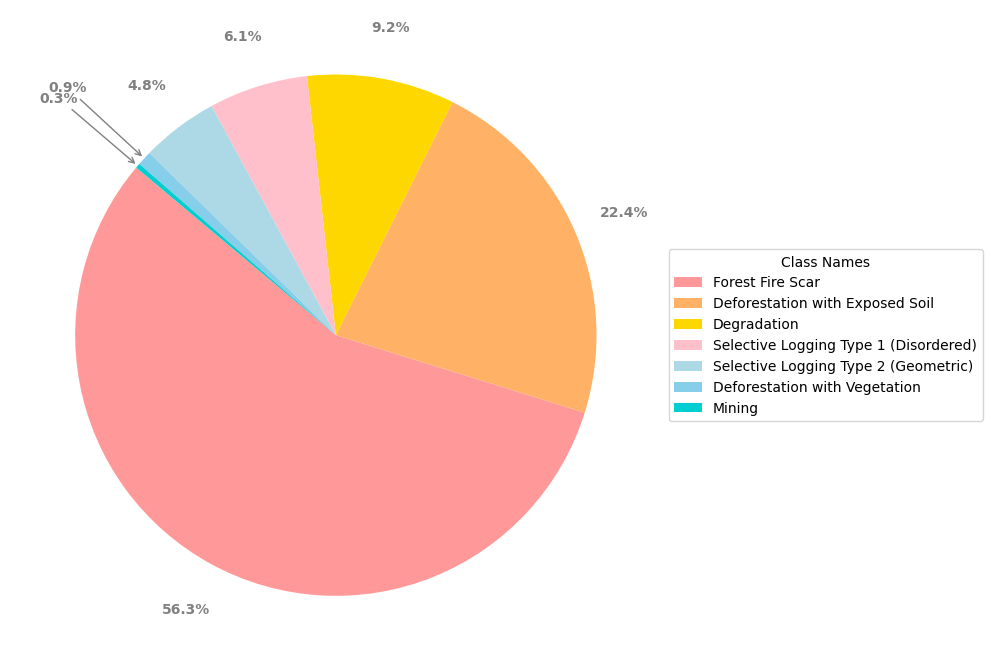

In [7]:
dict_classes, texts = get_texts("English")
save_graph("Graph1_EN",deter_graph1)

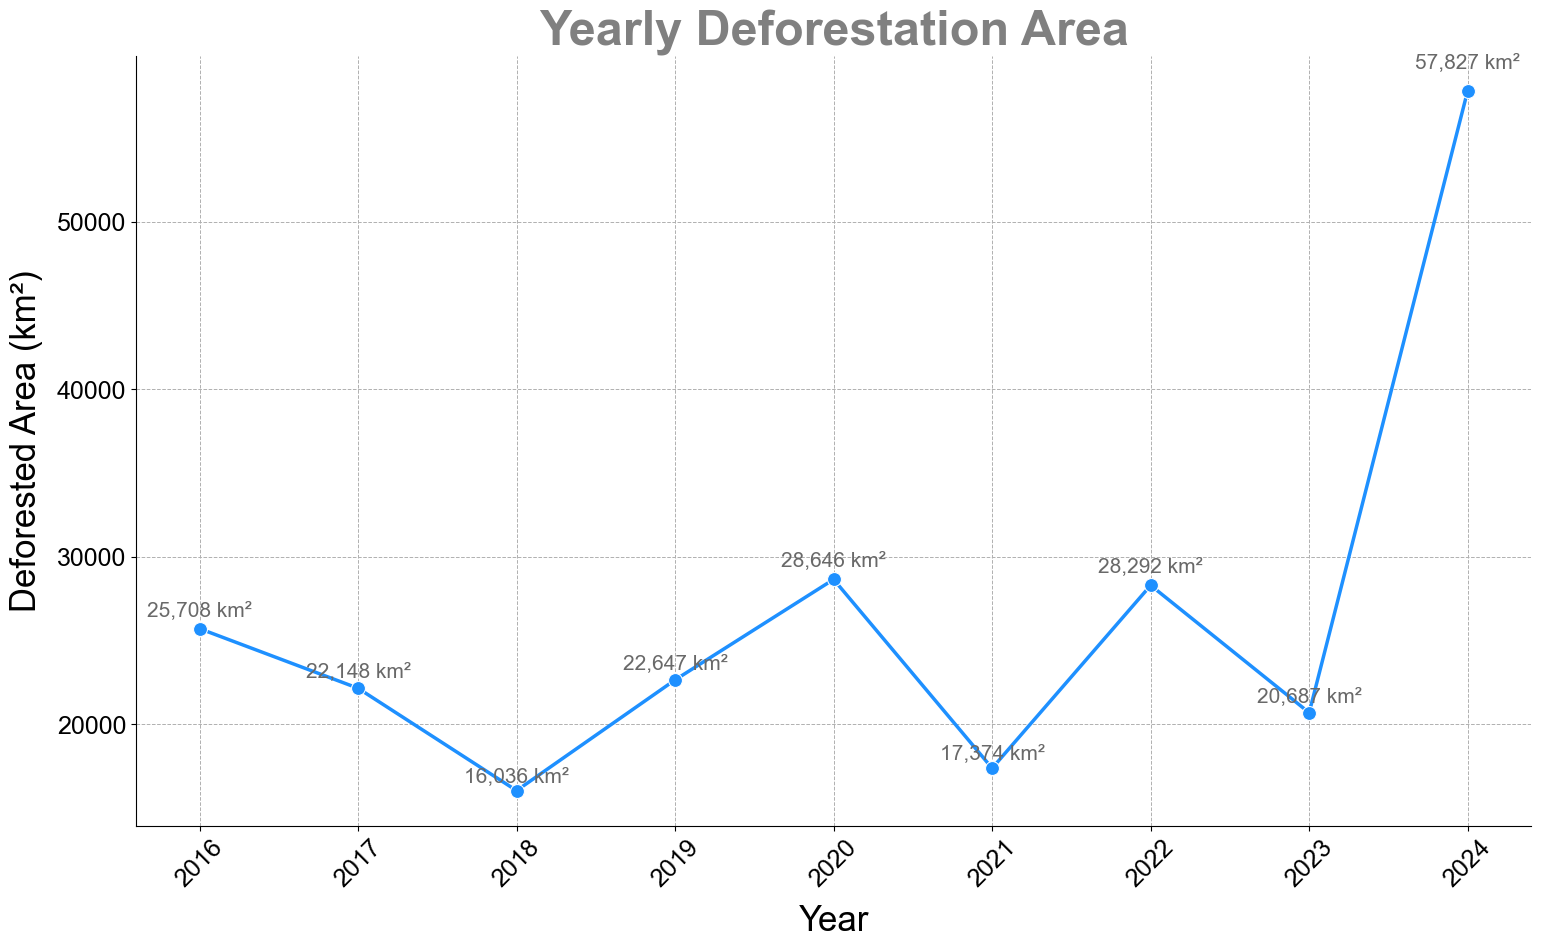

In [8]:
# YEARLY DEFORESTATION TRENDS
def deter_graph_yearly_trends():
    # Group by the 'ANO' column and calculate the sum of deforested area for each year
    df_yearly = df_deter.groupby('ANO')['AREAMUNKM'].sum().reset_index()
    
    # Set up the plot with a larger figure size and style improvements
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.set_theme(style="whitegrid")
    
    # Plotting with an enhanced line style
    ax = sns.lineplot(data=df_yearly, x='ANO', y='AREAMUNKM', marker="o", markersize=10, linewidth=2.5, color="dodgerblue")
    
    # Set title and labels with a larger font size
    ax.set_title('Yearly Deforestation Area', fontsize=35, fontweight='bold', color='gray')
    ax.set_xlabel('Year', fontsize=25, labelpad=10)
    ax.set_ylabel('Deforested Area (km²)', fontsize=25, labelpad=10)
    
    # Improve tick label size and rotation if needed
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    plt.xticks(rotation=45)  # Rotate x-axis labels if years are cluttered
    
    # Add grid and remove top/left spines for cleaner look
    sns.despine()
    ax.grid(True, which="both", linestyle='--', linewidth=0.7)
    
    # Adding data labels with a small vertical offset for better readability
    for year, area in zip(df_yearly['ANO'], df_yearly['AREAMUNKM']):
        ax.text(year, area + area * 0.02, f'{area:,.0f} km²', color='dimgray', ha='center', va='bottom', fontsize=15)
    
    return fig, ax

save_graph("Graph_Yearly",deter_graph_yearly_trends)

### Graph 2:

In [9]:
# DETER GRAPH 2: CLASS COUNT
def deter_graph2():
    # Prepare data for plotting
    class_count = pd.DataFrame(df_deter['CLASSNAME'].value_counts())
    class_count.columns = ['count']  # Rename column to 'count' for clarity
    class_count['DESC'] = class_count.index.map(dict_classes)
    class_count.reset_index(drop=True, inplace=True)

    # Increase figure size for better readability
    fig, ax = plt.subplots(figsize=(20, 30))  # Increased height for more space
    
    sns.set_theme(style="white")
    ax = sns.barplot(data=class_count, x='count', y='DESC', palette=palette_gen())
    
    # Customizing title and labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.yaxis.set_tick_params(labelsize=45, labelcolor= 'gray')
    
    sns.despine(left=True, bottom=True)
    
    # Adding data labels with increased offset
    for i, valor in enumerate(class_count['count']):
        p = (valor * 100) / class_count['count'].sum()
        qtd = f'{valor:,.0f} ({p:,.2f} %)'.replace(',', '.')
        
        # Adjust text position and size for better readability
        ax.text(valor + 150000, i, qtd, color= 'gray', fontsize=45, fontweight='bold', ha='right', va='center')
    
    return fig, ax


/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/1070759291.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=class_count, x='count', y='DESC', palette=palette_gen())
/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/1070759291.py:13: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  ax = sns.barplot(data=class_count, x='count', y='DESC', palette=palette_gen())


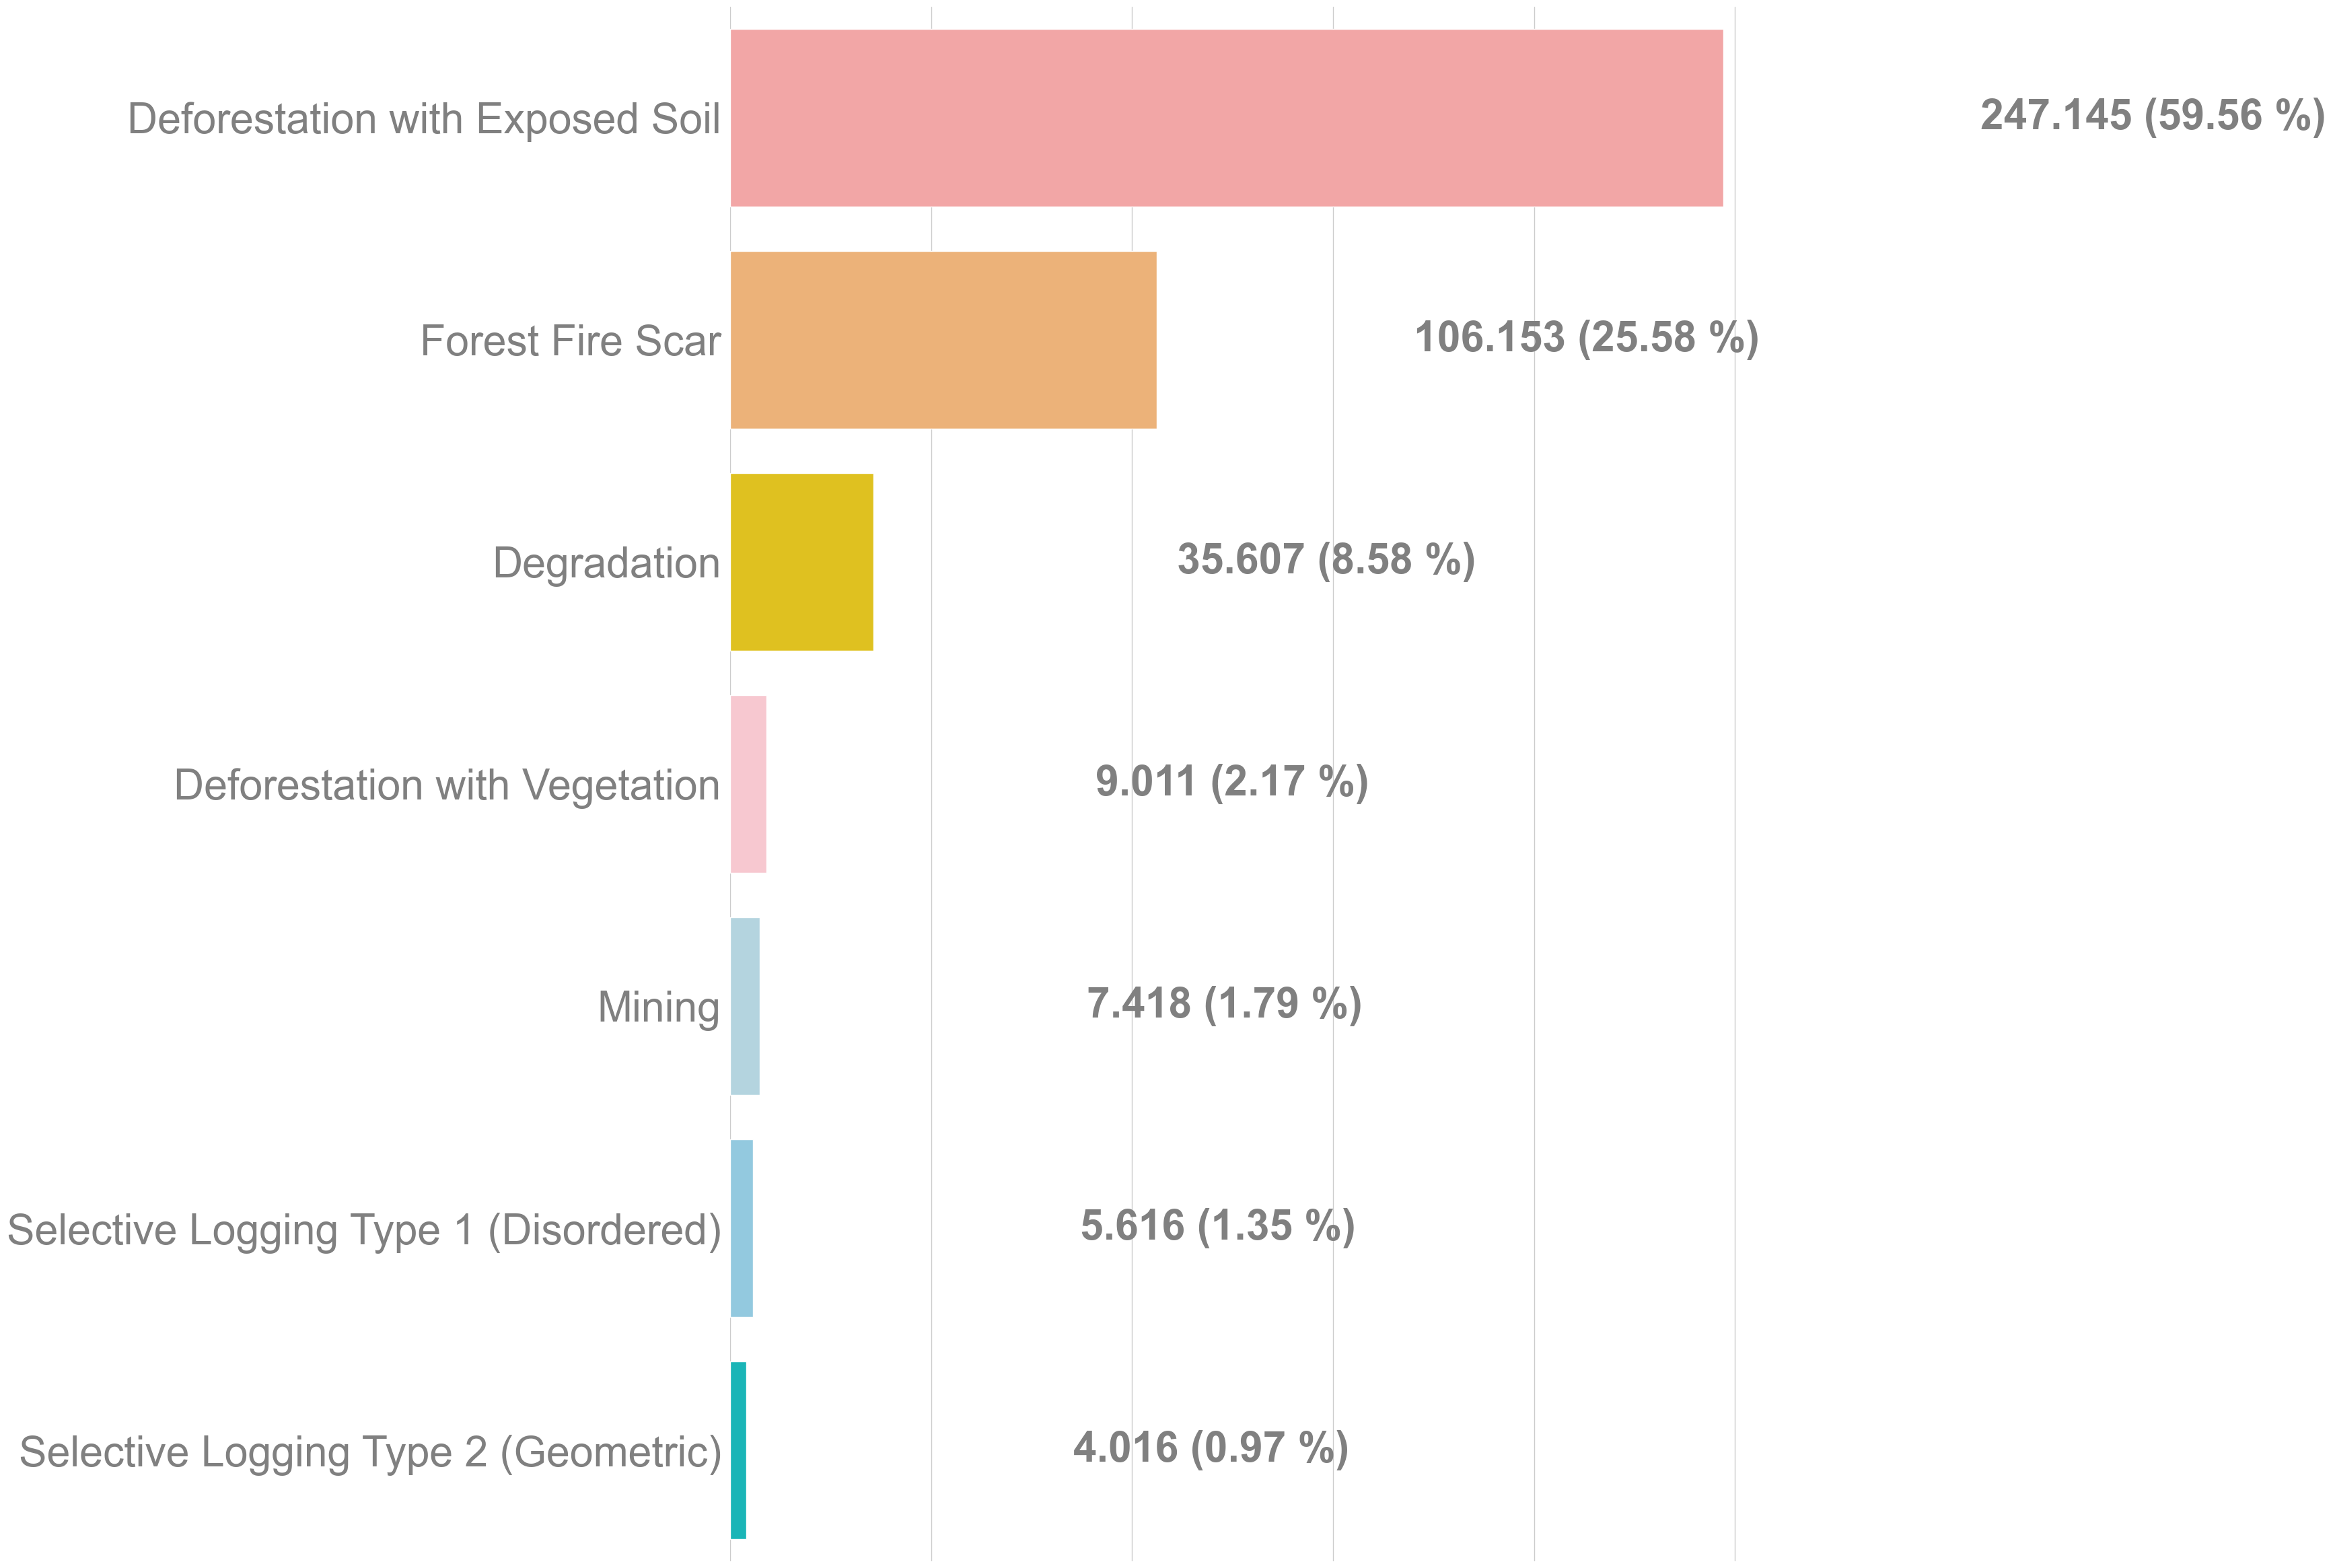

In [10]:
dict_classes, texts = get_texts("English")
save_graph("Graph2_EN",deter_graph2)

### Graph 3:

In [11]:
# DETER GRAPH 3: DEFORESTATION BY STATE
def deter_graph3():
    # Group by 'UF' and sum the deforested area, then sort in descending order
    gb_uf = df_deter.groupby('UF')['AREAMUNKM'].sum().sort_values(ascending=False)
    gb_uf = pd.DataFrame(gb_uf)
    
    # Map state codes to names and add a formatted column for display
    gb_uf['NOME_ESTADO'] = gb_uf.index.map(estados)
    gb_uf['NOME E SIGLA'] = gb_uf['NOME_ESTADO'] + ' (' + gb_uf.index + ')   '
    
    # Increase figure size for better readability
    fig, ax = plt.subplots(figsize=(20, 16))  # Increased height for more space
    
    sns.set_theme(style="white")
    ax = sns.barplot(data=gb_uf, x='AREAMUNKM', y='NOME E SIGLA', palette=palette_gen())
    
    # Customizing title and labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    ax.yaxis.set_tick_params(labelsize=18, labelcolor='gray')  # Increased label font size for visibility
    
    sns.despine(left=True, bottom=True)
    
    # Adding data labels with adjusted offsets
    for i, valor in enumerate(gb_uf['AREAMUNKM']):
        p = (valor * 100) / gb_uf['AREAMUNKM'].sum()
        qtd = f'{valor:,.0f} km² ({p:,.2f} %)'.replace(',', '.')
        
        # Adjust offset based on the value to prevent overlap
        offset = 15000 if valor > 50000 else (13000 if valor > 10000 else 12000)
        ax.text(valor + offset, i, qtd, color='gray', fontsize=18, fontweight='bold', ha='right', va='center')
    
    return fig, ax


/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/476149443.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=gb_uf, x='AREAMUNKM', y='NOME E SIGLA', palette=palette_gen())


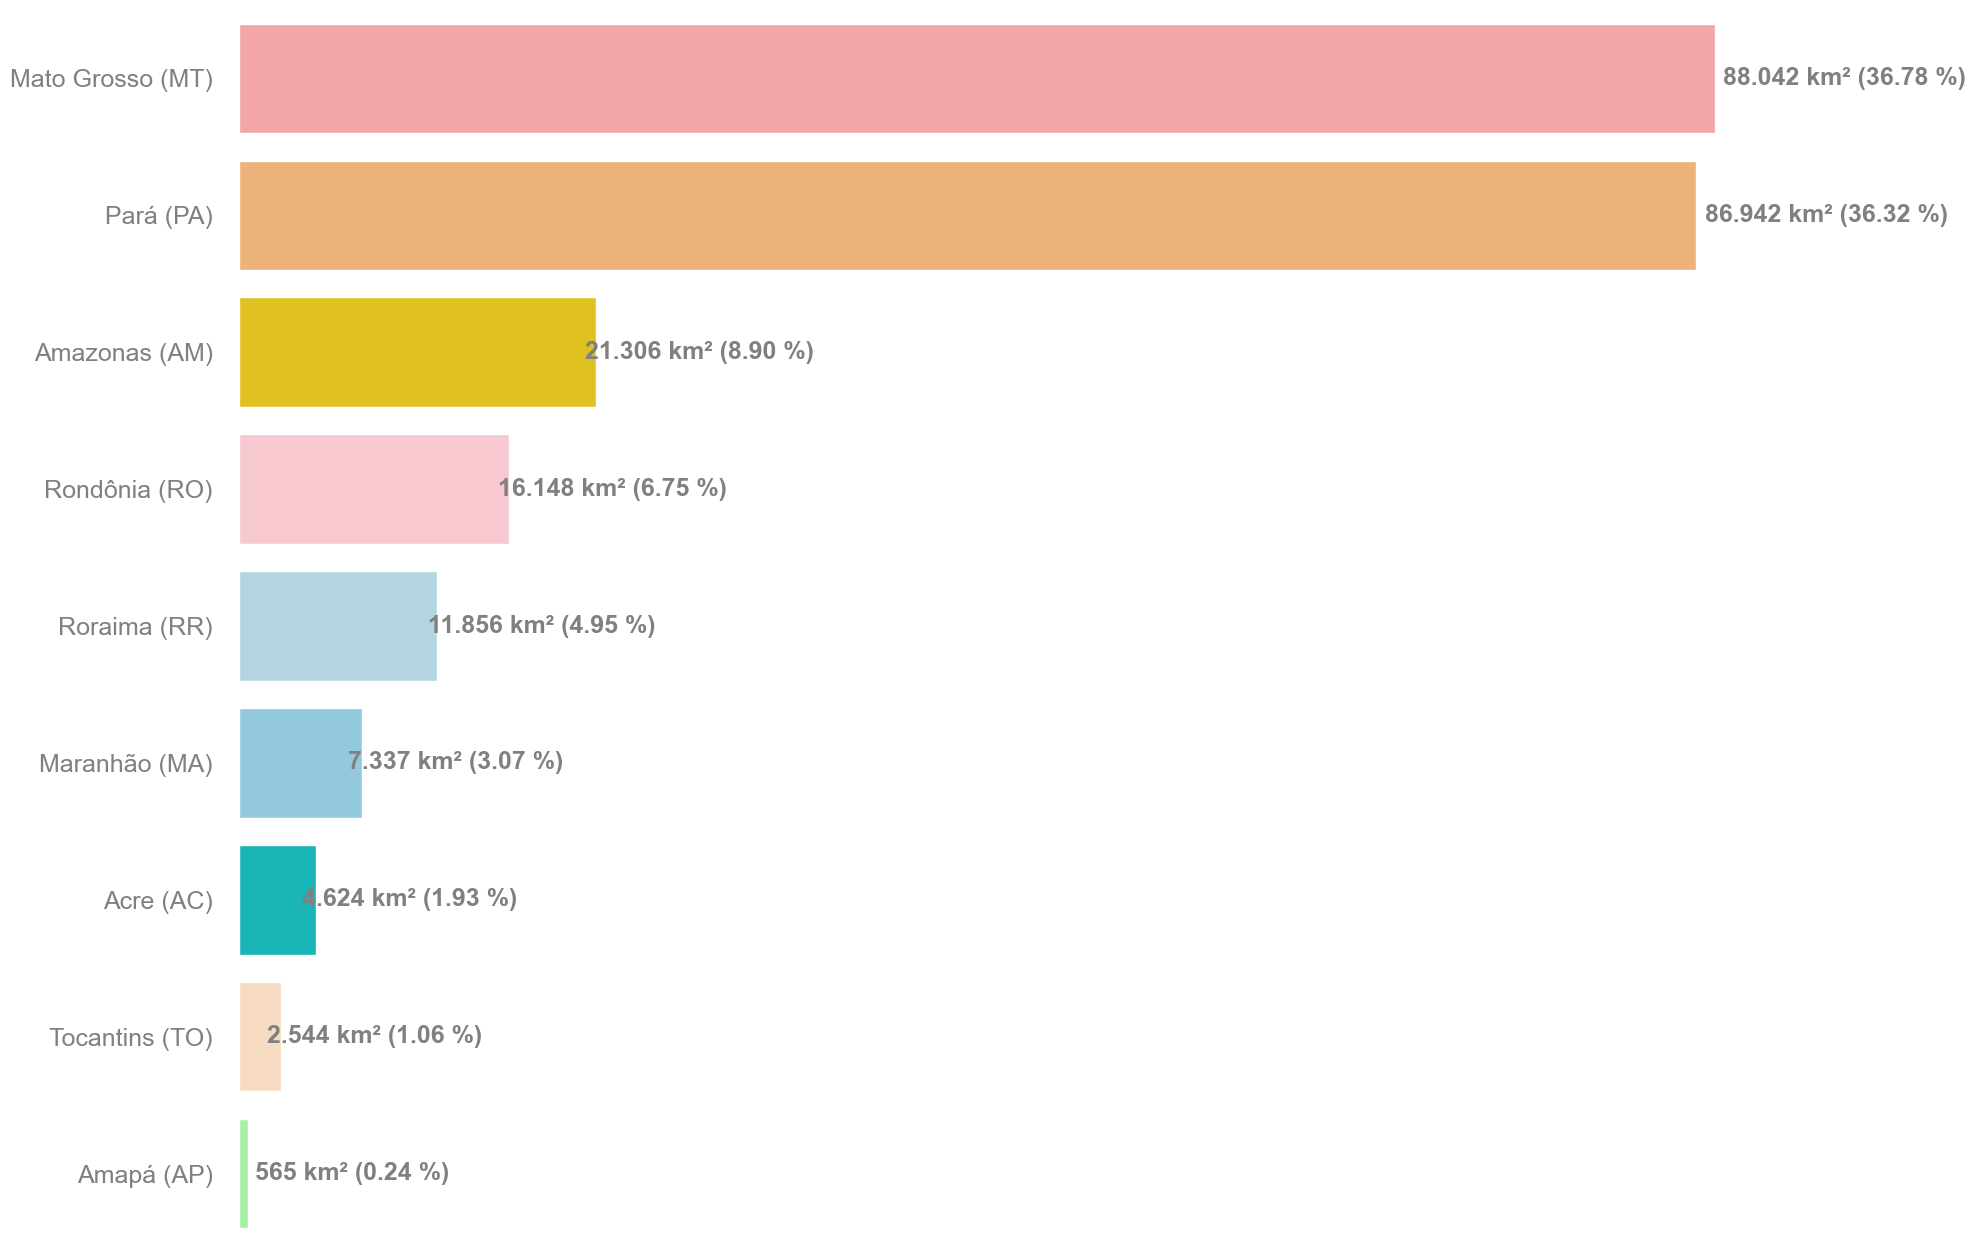

In [12]:
dict_classes, texts = get_texts("English")
save_graph("Graph3_EN",deter_graph3)

### Graph 4:

In [13]:
# DETER GRAPH 4: TOP CITIES BY DEFORESTED AREA
def deter_graph4(qtd=25, fs=(12, 18)):  # Increased default figure size for readability
    # Aggregate deforested area by city
    sum_areamunkm = df_deter.groupby('MUNICIPALI')['AREAMUNKM'].sum().reset_index()
    info_uf = df_deter.drop_duplicates(subset='MUNICIPALI')[['UF', 'MUNICIPALI']]
    res = pd.merge(sum_areamunkm, info_uf, on='MUNICIPALI', how='left')
    
    # Get top cities by deforested area
    top_cities = res.sort_values(by='AREAMUNKM', ascending=False).head(qtd)
    top_cities['MUN/UF'] = top_cities['MUNICIPALI'] + ' (' + top_cities['UF'].str.upper() + ') '
    
    # Create the plot with an increased figsize for better text fitting
    fig, ax = plt.subplots(figsize=fs)
    sns.set_theme(style="white")
    ax = sns.barplot(data=top_cities, x='AREAMUNKM', y='MUN/UF', palette=palette_gen(n_colors=top_cities.shape[0]))
    
    # Remove axis labels and ticks for a cleaner look
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.yaxis.set_tick_params(labelsize=20, labelcolor= 'gray')  # Increased label size for readability
    
    sns.despine(left=True, bottom=True)
    
    # Adding data labels with increased offset and font size
    for i, valor in enumerate(top_cities['AREAMUNKM']):
        qtd = f'{valor:,.0f} km²'.replace(',', '.')
        ax.text(valor + 2000, i, qtd, color='gray', fontsize=16, fontweight='bold', ha='right', va='center')
    
    return fig, ax


/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/3474919526.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_cities, x='AREAMUNKM', y='MUN/UF', palette=palette_gen(n_colors=top_cities.shape[0]))
/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/3474919526.py:15: UserWarning: 
The palette list has fewer values (9) than needed (25) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(data=top_cities, x='AREAMUNKM', y='MUN/UF', palette=palette_gen(n_colors=top_cities.shape[0]))


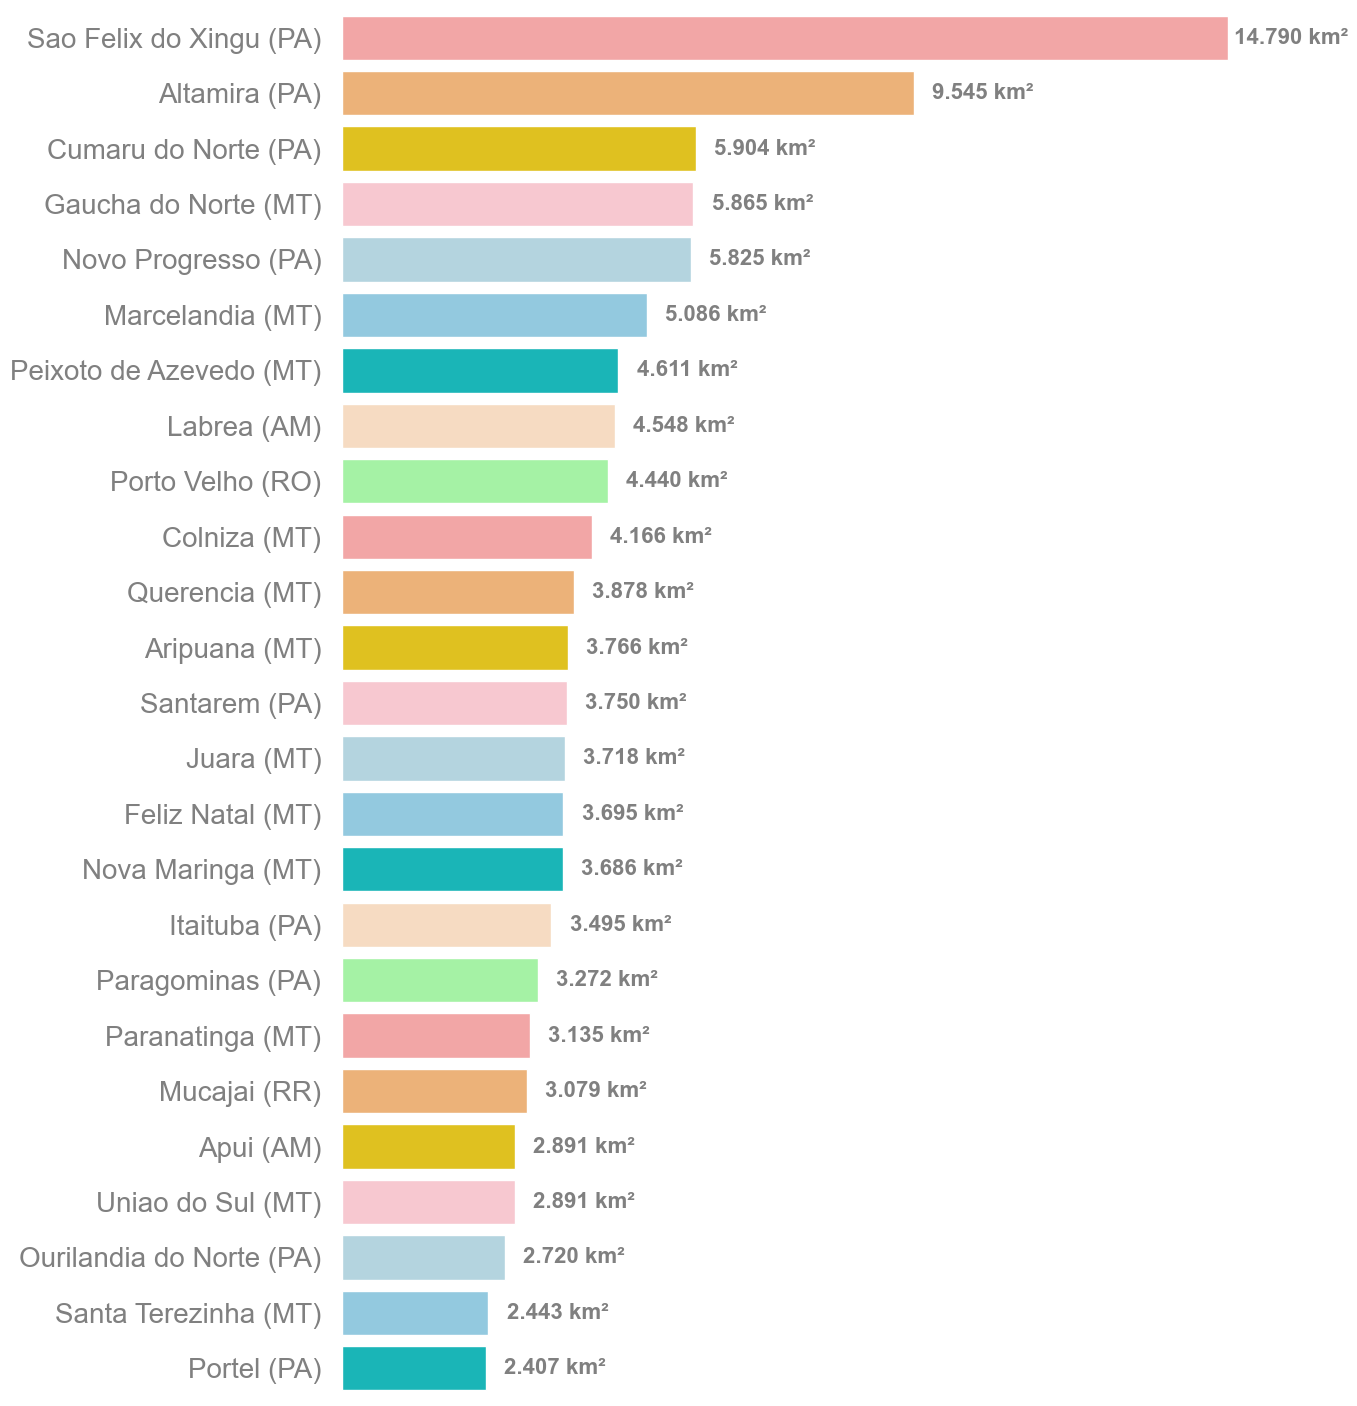

In [14]:
dict_classes, texts = get_texts("English")
save_graph("Graph4_EN",deter_graph4)

### Graph 5:

In [15]:
def deter_graph5():
    gb_ym = pd.DataFrame(df_deter.groupby('MES/ANO')['AREAMUNKM'].sum().sort_index()).reset_index()
    
    #Dropando mês incompleto
    most_recent_date = df_deter['VIEW_DATE'].max()
    last_day = pd.to_datetime(f'{most_recent_date.year}-{most_recent_date.month + 1}-01') - pd.Timedelta(days=1)
    
    if most_recent_date < last_day:
        # Se sim, excluir os dados desse mês
        gb_ym = gb_ym[gb_ym['MES/ANO'] < last_day.strftime('%Y-%m')]
    
    #maior valor de impacto mensal no ano
    gb_ym['ANO'] = pd.to_datetime(gb_ym['MES/ANO']).dt.year
    gb_ym['MES'] = pd.to_datetime(gb_ym['MES/ANO']).dt.month
    #max_year = pd.DataFrame(gb_ym.groupby('ANO').max()['AREAMUNKM']).rename(columns={'AREAMUNKM': 'MAX_DMG_YEAR'})
    max_year = gb_ym.groupby('ANO')['AREAMUNKM'].max().rename('MAX_DMG_YEAR').reset_index()
    gb_ym = pd.merge(gb_ym, max_year, on='ANO', how='left')
    
    #Meses que serão plotados
    dots = [True if row['AREAMUNKM'] == row['MAX_DMG_YEAR'] else False for index, row in gb_ym.iterrows()]


    
    fig, ax = plt.subplots(figsize=(27,6))
    gb_ym['MES/ANO'] = pd.to_datetime(gb_ym['MES/ANO'])
    
    ax.plot(gb_ym["MES/ANO"].values, gb_ym["AREAMUNKM"].values, lw=3, color = '#00c800', marker ="o", 
              markersize = 10, markerfacecolor = '#006400', markevery = dots)
    #ax.set_title(texts['title_deter_graph5'], fontsize = 45, color = gray, loc='center', pad=17)
    ax.set_frame_on(False)
    ax.xaxis.set_tick_params(labelsize=14, labelcolor = 'gray')
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray', axis='both')
    
    meses = gb_ym['MES/ANO'].dt.month
    first_month = gb_ym["MES/ANO"].min()
    last_month = gb_ym["MES/ANO"].max()
    ticks = pd.date_range(start=first_month, end=last_month, freq='4MS')
    ax.set_xticks(ticks)
    ax.xaxis.set_major_formatter(mdates.DateFormatter(texts['date_format2']))
    ax.set_xlim(first_month - DateOffset(months=1), last_month)
    
    for i in range(0, gb_ym.shape[0]):
    
        if gb_ym['AREAMUNKM'][i] == gb_ym['MAX_DMG_YEAR'][i]:
            ax.annotate(f"{gb_ym['AREAMUNKM'][i]:.2f} km²\n  ({gb_ym['MES/ANO'][i].strftime(texts['date_format2'])})", 
                        xy=(gb_ym["MES/ANO"][i], gb_ym['AREAMUNKM'][i]), 
                        xytext=(-35, 15), textcoords='offset points',
                        color='#006400', weight="bold", fontsize=16,
                        )#arrowprops=dict(arrowstyle="->", color='#006400')
    
    plt.xticks(rotation=0);
    
    return fig, ax

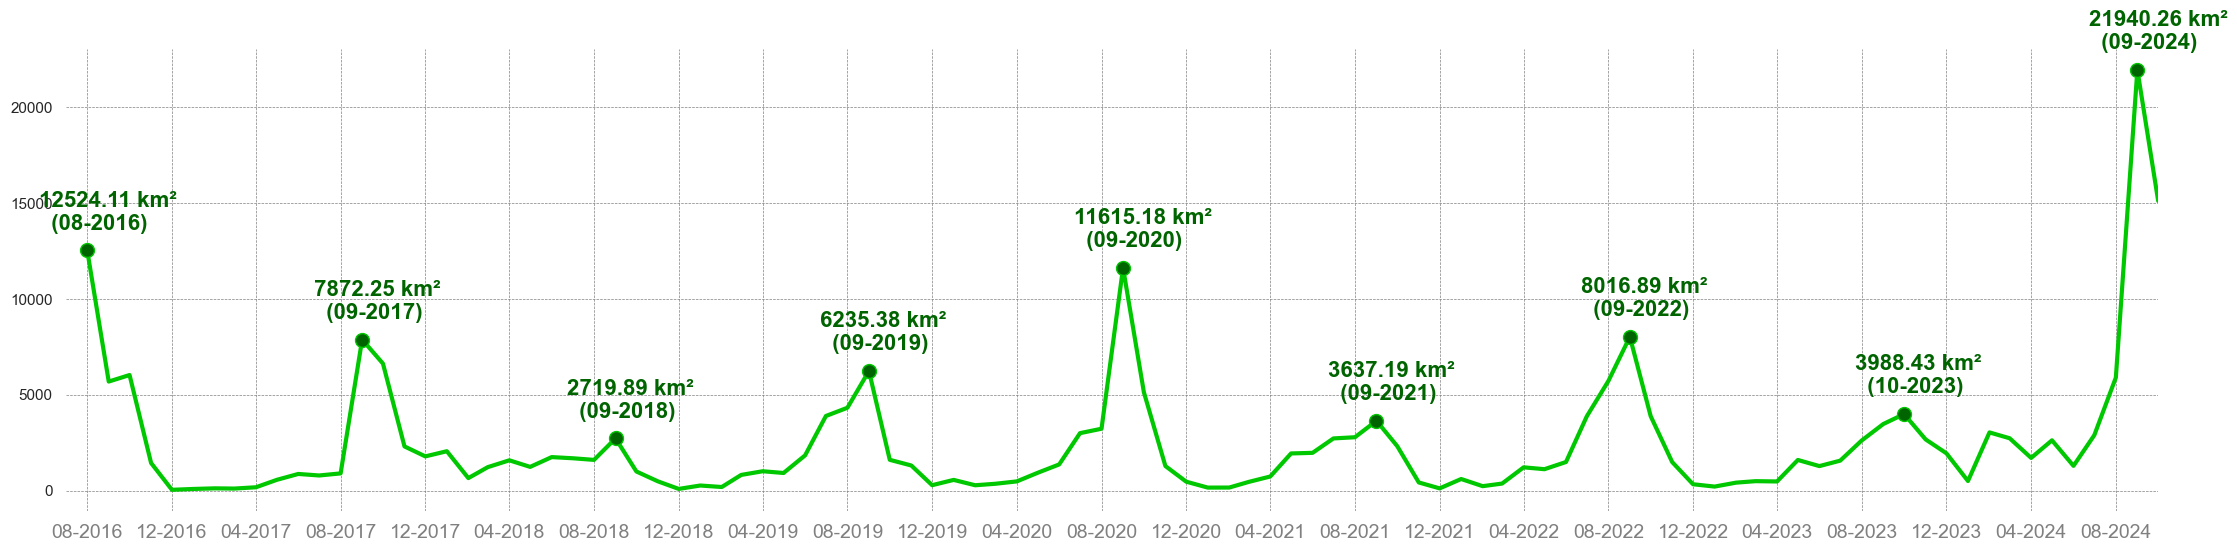

In [16]:
dict_classes, texts = get_texts("English")
save_graph("Graph5_EN",deter_graph5)

### Graph 6:

In [17]:
def deter_graph6():
    complete_years = df_deter.groupby('ANO')['MES'].nunique().reset_index()
    complete_years = complete_years[complete_years['MES'] == 12]['ANO']

    y1 = complete_years.min()
    y2 = complete_years.max()
    
    df_month = df_deter[df_deter['ANO'].isin(complete_years)]['AREAMUNKM'].groupby(df_deter['MES']).sum().sort_index()
    df_month = pd.DataFrame(df_month)

    fig, ax = plt.subplots(figsize=(17,5))
    
    # Normalize and create a list of colors for each bar
    norm = plt.Normalize(df_month['AREAMUNKM'].min() - 50000, df_month['AREAMUNKM'].max() + 20000)
    colors = [plt.cm.Greens(norm(value)) for value in df_month['AREAMUNKM']]
    
    # Pass the color list to the palette parameter
    ax = sns.barplot(data=df_month, x=df_month.index, y='AREAMUNKM', palette=colors)
    # ax.set_title(texts['title_deter_graph6'].format(y1, y2), fontsize=23, color=gray, loc='center', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    lbs = ast.literal_eval(texts['labels_deter_graph6'])
    plt.xticks(ticks=range(0, 12), labels=lbs)
    ax.set_frame_on(False)
    plt.gca().set_yticks([])

    # Add labels on top of bars
    for i, area in enumerate(df_month['AREAMUNKM']):
        qtd = f'{area:,.0f} km²'.replace(',', '.')
        offset = 750
        ax.text(i, area + offset, qtd, color='gray', fontsize=12, ha='center', va='center')

    return fig, ax, y1, y2


In [18]:
def save_graph_wperiod(file_name,graph_func):
    fig, ax, y1, y2 = graph_func()
    fig.savefig(f"../Visualizations/DETER/Graphs/{file_name}.png", bbox_inches='tight', pad_inches=0.1)

    period = f"{y1};{y2}"
    with open(f"../Visualizations/DETER/Graphs/{file_name}_period.txt", "w") as text_file:
        text_file.write(period)

/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/760729846.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_month, x=df_month.index, y='AREAMUNKM', palette=colors)


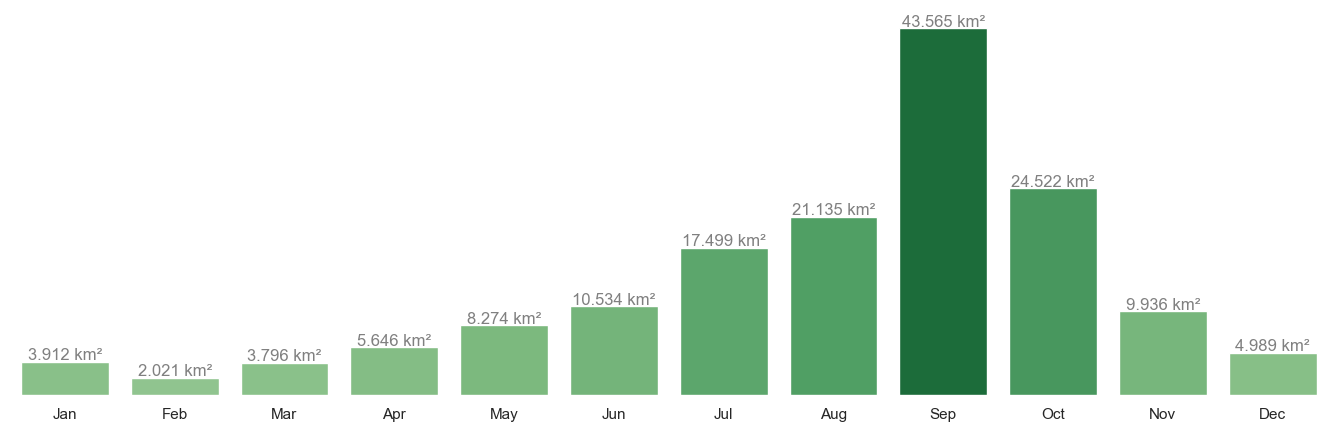

In [19]:
dict_classes, texts = get_texts("English")
save_graph_wperiod("Graph6_EN",deter_graph6)

### Graph 7:

In [20]:
def deter_graph7():
    complete_years = df_deter.groupby('ANO')['MES'].nunique().reset_index()
    complete_years = complete_years[complete_years['MES'] == 12]['ANO']
    # df_month = df_deter[df_deter['ANO'].isin(complete_years)]['AREAMUNKM'].groupby(df_deter['MES']).sum().sort_index()
    # df_month = pd.DataFrame(df_month)
    complete_years_df = df_deter[df_deter['ANO'].isin(complete_years)]
    complete_years_df = pd.DataFrame(complete_years_df['AREAMUNKM'].groupby(df_deter['ANO']).sum().sort_index())
    complete_years_df = complete_years_df.reset_index(drop=False)
    # complete_years_df['VARIACAO_AREA'] = complete_years_df["AREAMUNKM"].diff().fillna(complete_years_df["AREAMUNKM"]).astype("float64")
    # complete_years_df["Medidas"] = ["absolute"] + ["relative"] * 6

    fig, ax = plt.subplots(figsize=(20,7))
    ax = sns.barplot(data=complete_years_df, x=complete_years_df['ANO'], y=complete_years_df['AREAMUNKM'],color='#b39ddb')
    #ax.set_title(texts['title_deter_graph7'], fontsize = 23, color = gray, loc='center', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_frame_on(False)
    plt.gca().set_yticks([])
    
    for i, area in enumerate(complete_years_df['AREAMUNKM']):
        qtd = f'{area:,.0f} km²'.replace(',', '.')
        offset = -1500
        
        ax.text(i, area + offset, qtd, color= "#ffffff", fontsize=18, ha='center', va='center', fontweight='bold')
        
        if (i != complete_years_df.shape[0]-1):
            
            dif = complete_years_df['AREAMUNKM'].iloc[i+1] - complete_years_df['AREAMUNKM'].iloc[i]
            
            if dif < 0:
                fcolor = '#00c800'
                ecolor = '#00c800'
                offs = 0.74
                prefix = ''
            else:
                fcolor = '#ff0000'
                ecolor = '#ff0000'
                offs = 0.26
                prefix = '+'
            
            arrow = mpatches.FancyArrowPatch((i + 0.5, complete_years_df['AREAMUNKM'].iloc[i]), (i+0.5, complete_years_df['AREAMUNKM'].iloc[i+1]),
                                         mutation_scale=45, facecolor=fcolor,edgecolor=ecolor)
            ax.add_patch(arrow)
    
            pct = (dif*100) / complete_years_df['AREAMUNKM'].iloc[i]
            textarea = complete_years_df['AREAMUNKM'].iloc[i] +  (dif/2)
            qtd = f'{prefix}{dif:.0f}\n{prefix}{pct:.2f}%'
            ax.text(i + offs, textarea, qtd, color= fcolor, fontsize=15, ha='center', va='center')
    
    return fig, ax

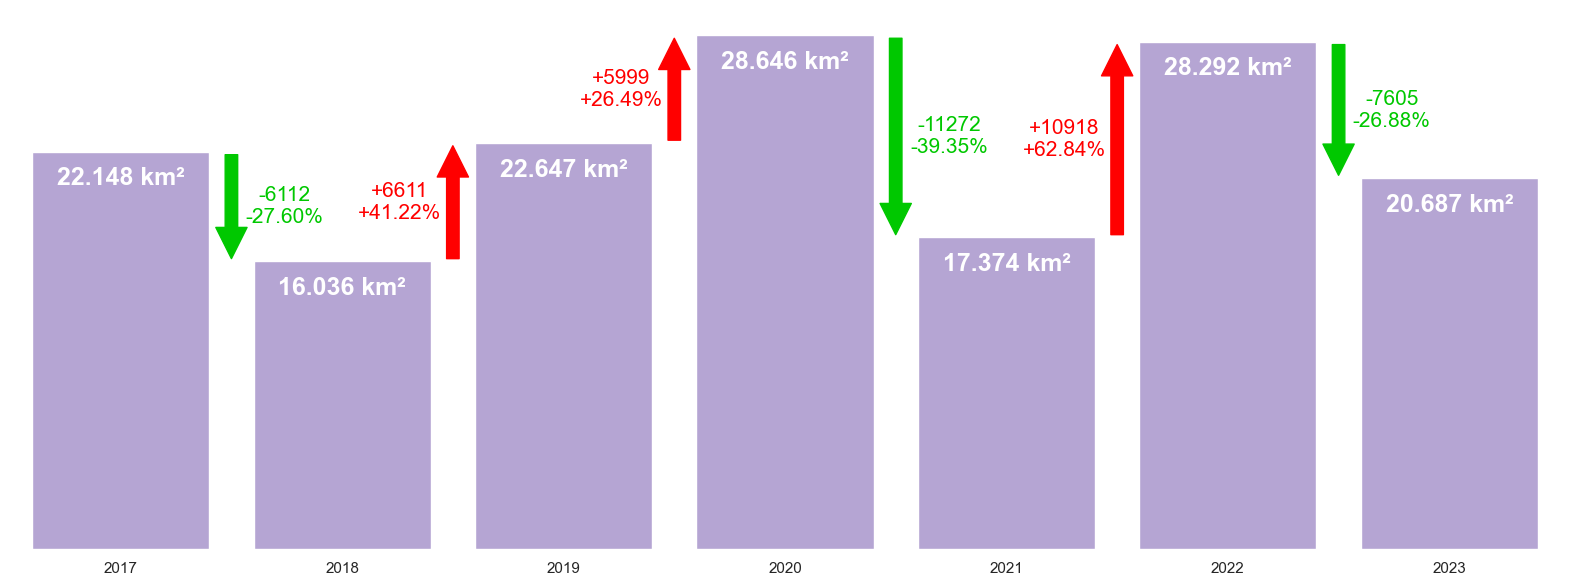

In [21]:
dict_classes, texts = get_texts("English")
save_graph("Graph7_EN",deter_graph7)

### Graph 8:

In [22]:
def deter_graph8():
    fig, axs = plt.subplots(3, 3, figsize=(20,20), sharey=True)
    #fig.suptitle(texts['graph8_title'], fontsize = 40, color = gray, fontweight='bold')
    plt.subplots_adjust(wspace=0.05, hspace=0.3)  
    sns.set_theme(style="white")
    
    lst_states = list(estados.keys())
    all_classes = sorted(df_deter['CLASSNAME'].unique())
    
    k=0
    
    for i in range(3):
        for j in range(3):
            
            df_state = df_deter[df_deter['UF'] == lst_states[k]]
            df_state_summed = df_state.groupby('CLASSNAME')['AREAMUNKM'].sum().reset_index()
            df_state_complete = pd.DataFrame({'CLASSNAME': all_classes})
            df_state_complete = df_state_complete.merge(df_state_summed, on='CLASSNAME', how='left').fillna(0)
            df_state_complete['DESC'] = df_state_complete['CLASSNAME'].map(dict_classes)
            palette = palette_gen(n_colors=len(all_classes))

    
            sns.barplot(data=df_state_complete, x='AREAMUNKM', y = 'DESC', palette=palette, ax=axs[i, j])
            axs[i, j].set_xlabel('');
            axs[i, j].set_ylabel('');
            axs[i, j].yaxis.set_tick_params(labelsize=15, labelcolor = 'gray')
            sns.despine(left = True, bottom = True)
            axs[i, j].grid(color='gray', linestyle='--', linewidth=0.5)
            axs[i, j].set_title(estados[lst_states[k]] + ' (' + lst_states[k] + ')', fontsize=25, color= 'gray', fontweight='bold')

            
            k+=1
    return fig, axs

/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/3476634026.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_state_complete, x='AREAMUNKM', y = 'DESC', palette=palette, ax=axs[i, j])
/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/3476634026.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_state_complete, x='AREAMUNKM', y = 'DESC', palette=palette, ax=axs[i, j])
/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/3476634026.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barp

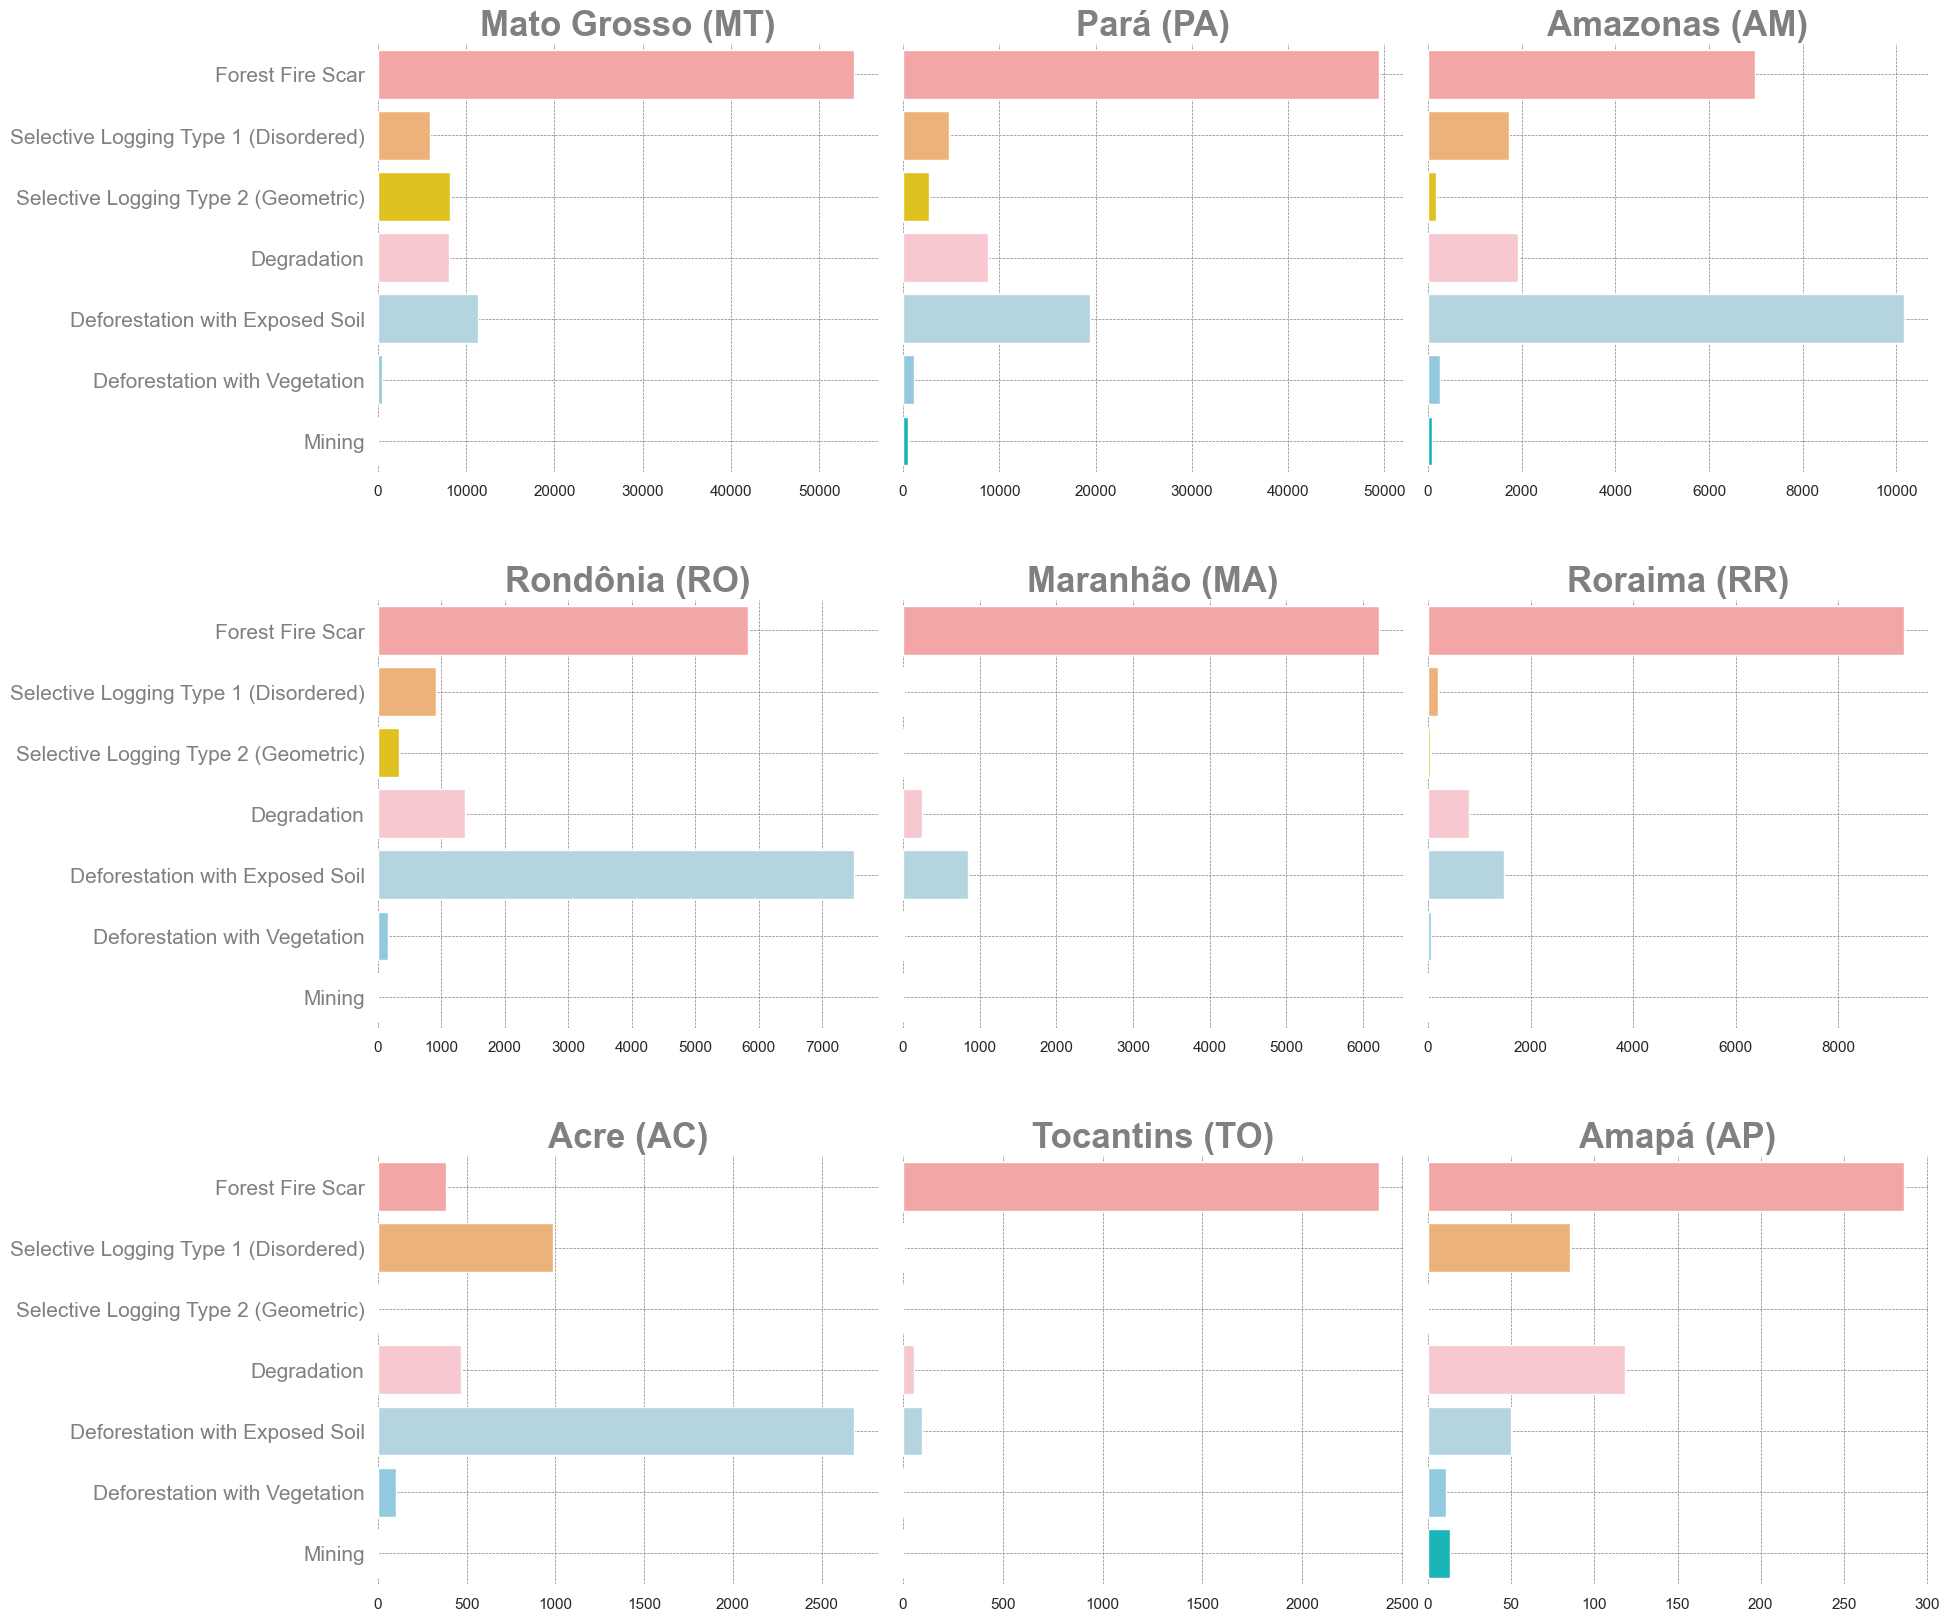

In [23]:
dict_classes, texts = get_texts("English")
save_graph("Graph8_EN",deter_graph8)

### Graph 9:

In [24]:
# DETER GRAPH 9: TOP UCs BY DEFORESTED AREA
def deter_graph9():
    # Aggregate deforested area by UC (Conservation Unit)
    sum_areamunkm = df_deter.groupby('UC')['AREAMUNKM'].sum().reset_index()
    info_uc = df_deter.drop_duplicates(subset='UC')[['UC', 'UF', 'MUNICIPALI']]
    res = pd.merge(sum_areamunkm, info_uc, on='UC', how='left')
    
    # Get top 25 UCs by deforested area
    top_ucs = res.sort_values(by='AREAMUNKM', ascending=False).head(25)
    top_ucs['UC/LOC'] = top_ucs['UC'] + ' (' + top_ucs['MUNICIPALI'].str.upper() + '/' + top_ucs['UF'].str.upper() + ')'
    
    # Increase figure size for better readability
    fig, ax = plt.subplots(figsize=(16, 24))  # Significantly increased height for maximum space
    
    sns.set_theme(style="white")
    ax = sns.barplot(data=top_ucs, x='AREAMUNKM', y='UC/LOC', palette=palette_gen(n_colors=top_ucs.shape[0]))
    
    # Remove axis labels and ticks for a cleaner look
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.yaxis.set_tick_params(labelsize=20, labelcolor='gray')  # Further increased label size for visibility
    
    sns.despine(left=True, bottom=True)
    
    # Adding data labels with greater offsets and larger font size for better readability
    for i, valor in enumerate(top_ucs['AREAMUNKM']):
        qtd = f'{valor:,.0f} km²'.replace(',', '.')
        
        # Adjust offset based on the value to prevent overlap, with increased base offset
        offset = 250 if valor > 1000 else (200 if valor > 200 else (180 if valor > 100 else 150))
        ax.text(valor + offset, i, qtd, color='gray', fontsize=18, fontweight='bold', ha='right', va='center')  # Larger font size
    
    return fig, ax


/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/2149681573.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_ucs, x='AREAMUNKM', y='UC/LOC', palette=palette_gen(n_colors=top_ucs.shape[0]))
/var/folders/mk/np6rblqn5jzdcb48rl2zt3bm0000gn/T/ipykernel_42991/2149681573.py:16: UserWarning: 
The palette list has fewer values (9) than needed (25) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(data=top_ucs, x='AREAMUNKM', y='UC/LOC', palette=palette_gen(n_colors=top_ucs.shape[0]))


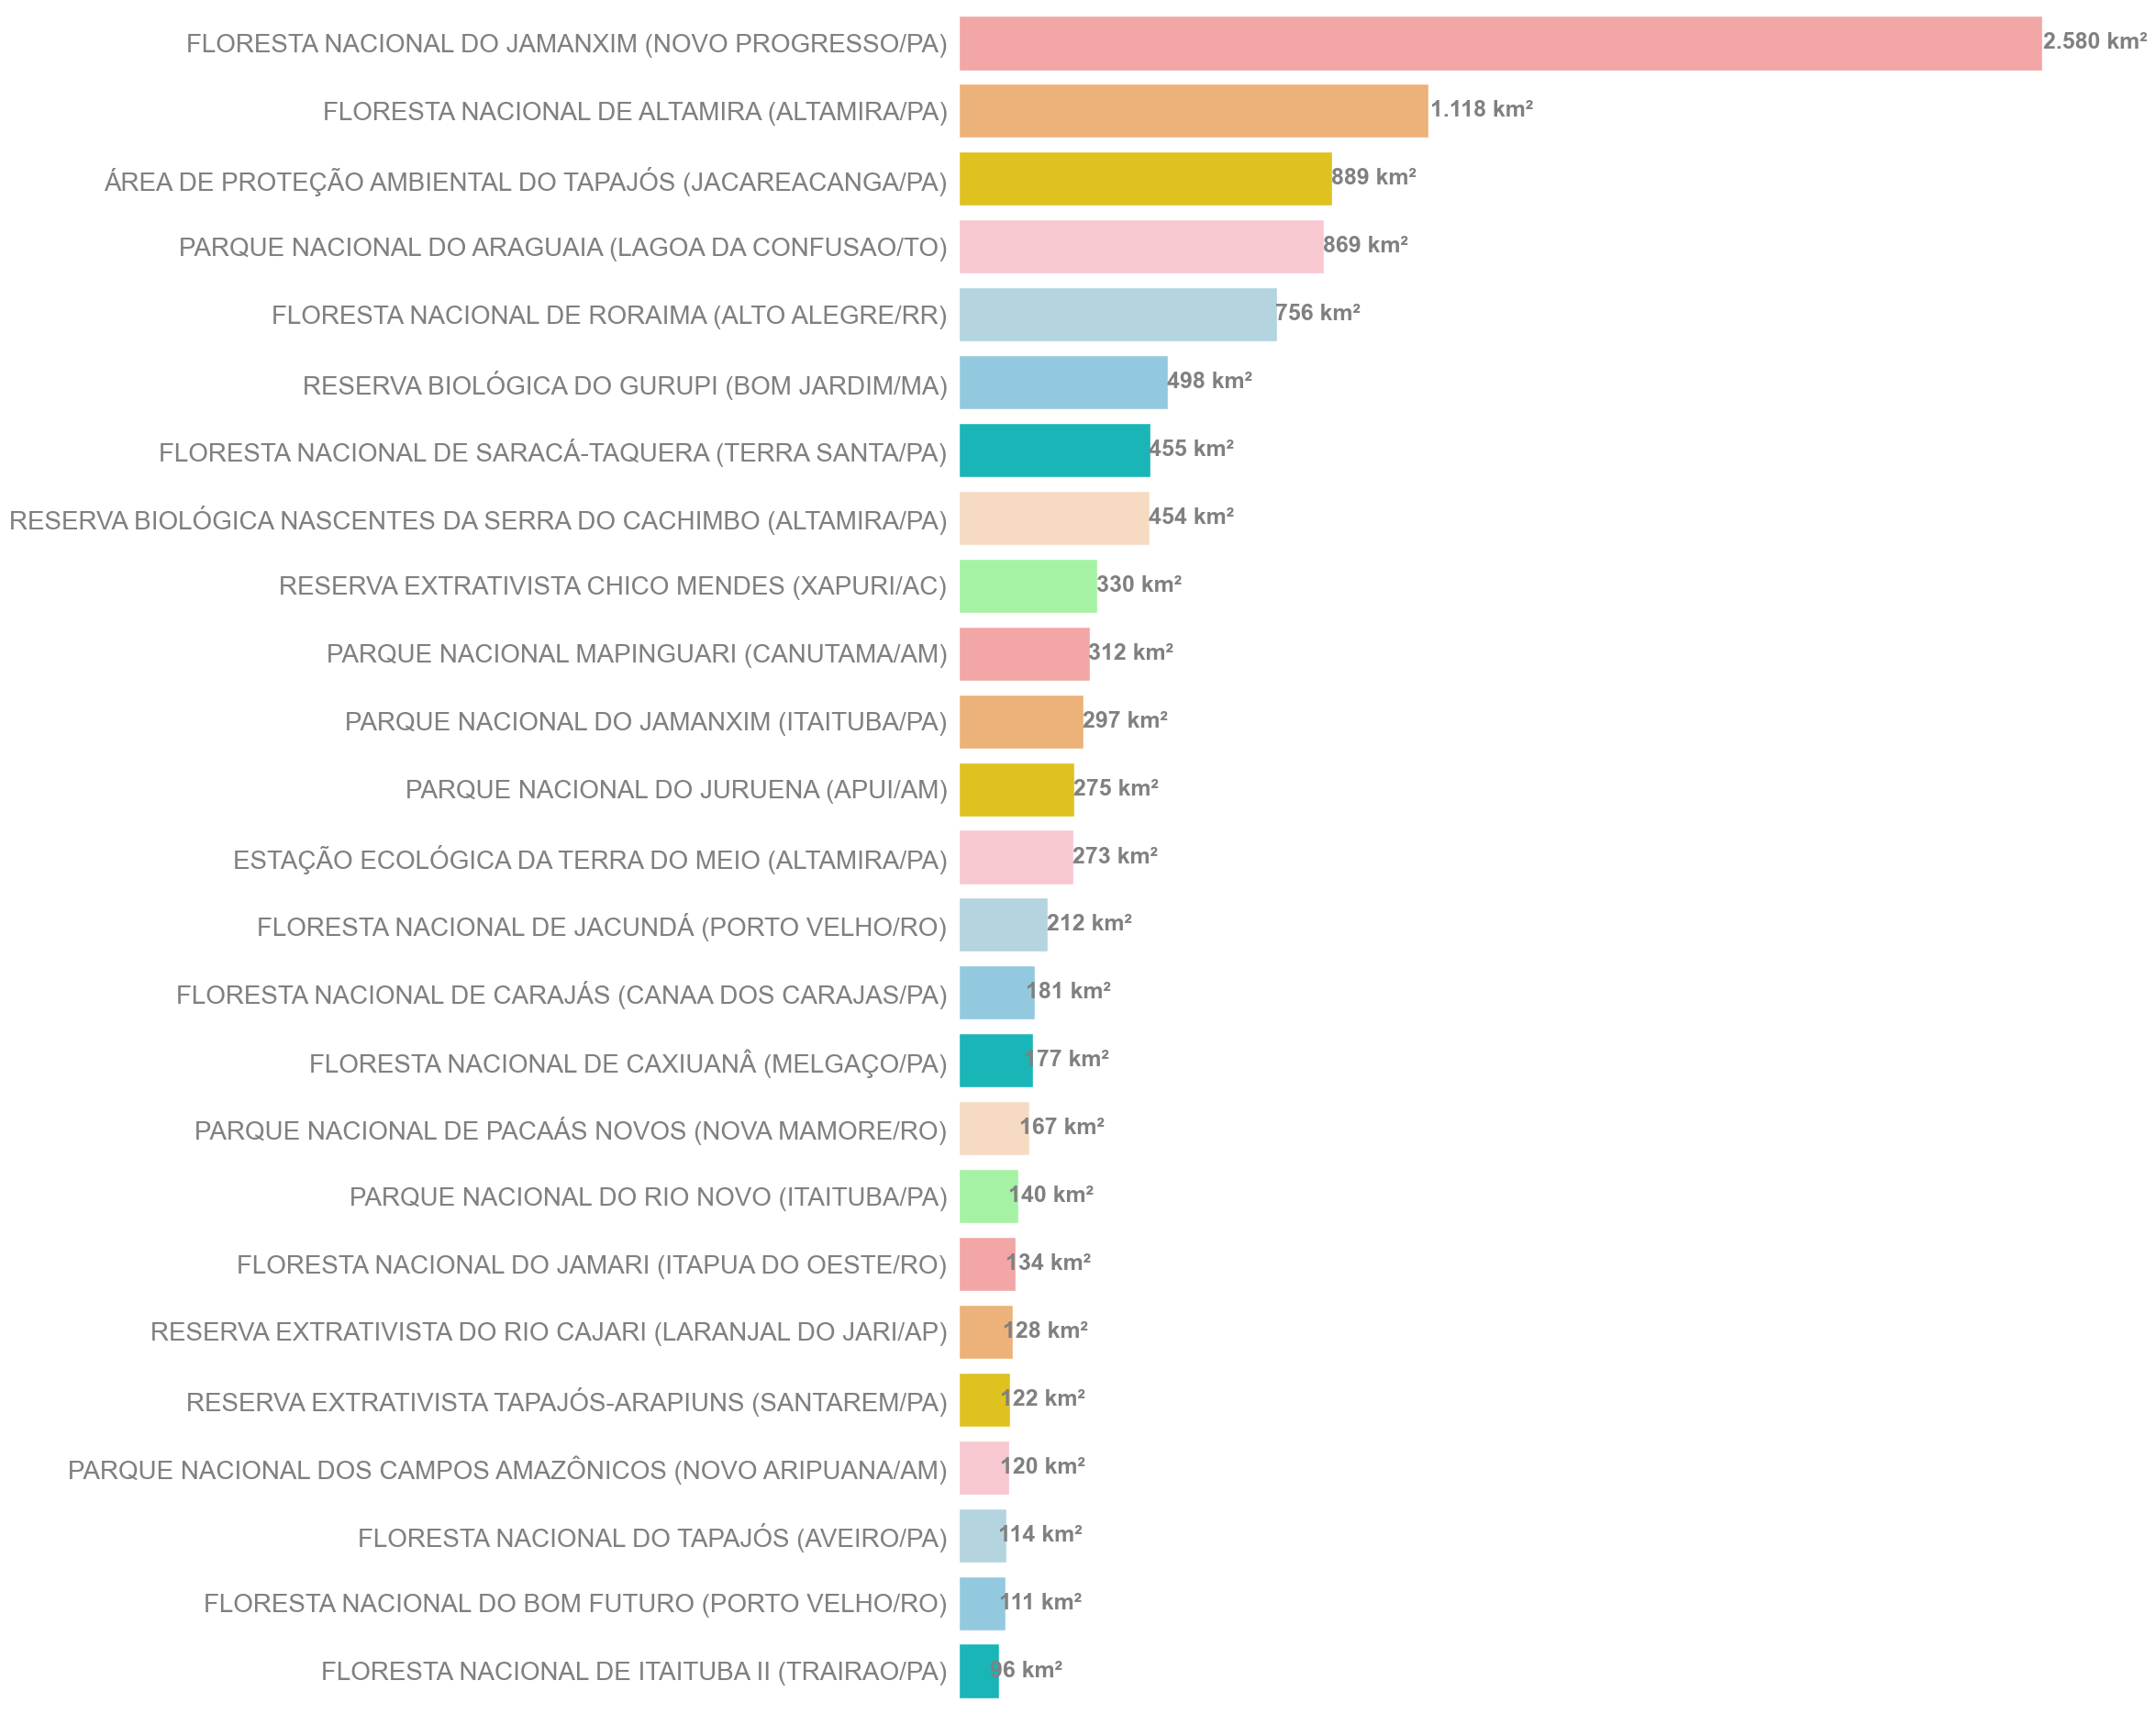

In [25]:
dict_classes, texts = get_texts("English")
save_graph("Graph9_EN",deter_graph9)

### Graph 10:

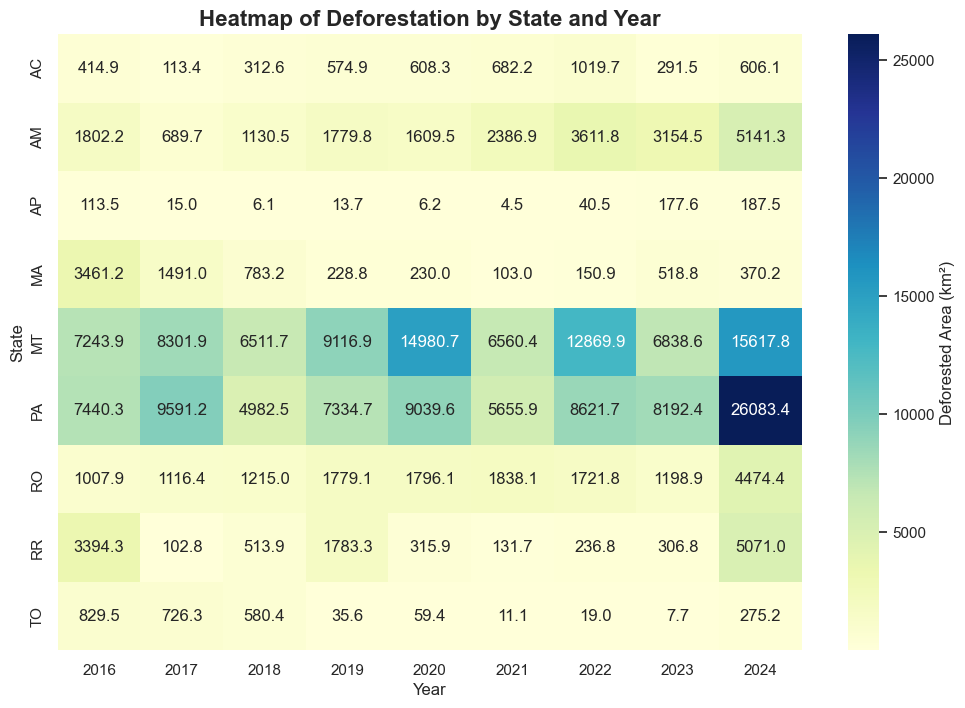

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def deter_graph10():
    # Group data by 'UF' and 'ANO', summing 'AREAMUNKM'
    df_heatmap = df_deter.groupby(['UF', 'ANO'])['AREAMUNKM'].sum().unstack().fillna(0)
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(df_heatmap, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'Deforested Area (km²)'})
    ax.set_title("Heatmap of Deforestation by State and Year", fontsize=16, fontweight='bold')
    ax.set_xlabel("Year")
    ax.set_ylabel("State")
    
    plt.show()
    return fig, ax

save_graph("heatmap",deter_graph10)

### Graph 11:

In [27]:
# def deter_graph11():
#     import plotly.express as px

#     # Summing up 'AREAMUNKM' by 'MUNICIPALI' and getting the top 20
#     df_bubble = df_deter.groupby(['MUNICIPALI', 'UF'])['AREAMUNKM'].sum().reset_index()
#     df_bubble = df_bubble.sort_values(by='AREAMUNKM', ascending=False).head(20)
    
#     # Create interactive bubble plot
#     fig = px.scatter(df_bubble, x='AREAMUNKM', y='MUNICIPALI', size='AREAMUNKM', color='UF',
#                      hover_name='MUNICIPALI', title="Interactive Bubble Plot of Deforestation by Municipality",
#                      labels={"AREAMUNKM": "Deforested Area (km²)", "MUNICIPALI": "Municipality"})
    
#     fig.update_layout(title_font_size=18)
    
#     # Save the Plotly figure as an image
#     fig.write_image("bubble_plot.png")
    
#     return fig

# # deter_graph11()

def deter_graph11():
    import plotly.express as px

    # Summing up 'AREAMUNKM' by 'MUNICIPALI' and getting the top 20
    df_bubble = df_deter.groupby(['MUNICIPALI', 'UF'])['AREAMUNKM'].sum().reset_index()
    df_bubble = df_bubble.sort_values(by='AREAMUNKM', ascending=False).head(20)
    
    # Create interactive bubble plot
    fig = px.scatter(df_bubble, x='AREAMUNKM', y='MUNICIPALI', size='AREAMUNKM', color='UF',
                     hover_name='MUNICIPALI', title="Interactive Bubble Plot of Deforestation by Municipality",
                     labels={"AREAMUNKM": "Deforested Area (km²)", "MUNICIPALI": "Municipality"})
    
    fig.update_layout(title_font_size=18)
        
    return fig

deter_graph11()


ModuleNotFoundError: No module named 'plotly'

### Graph 12:

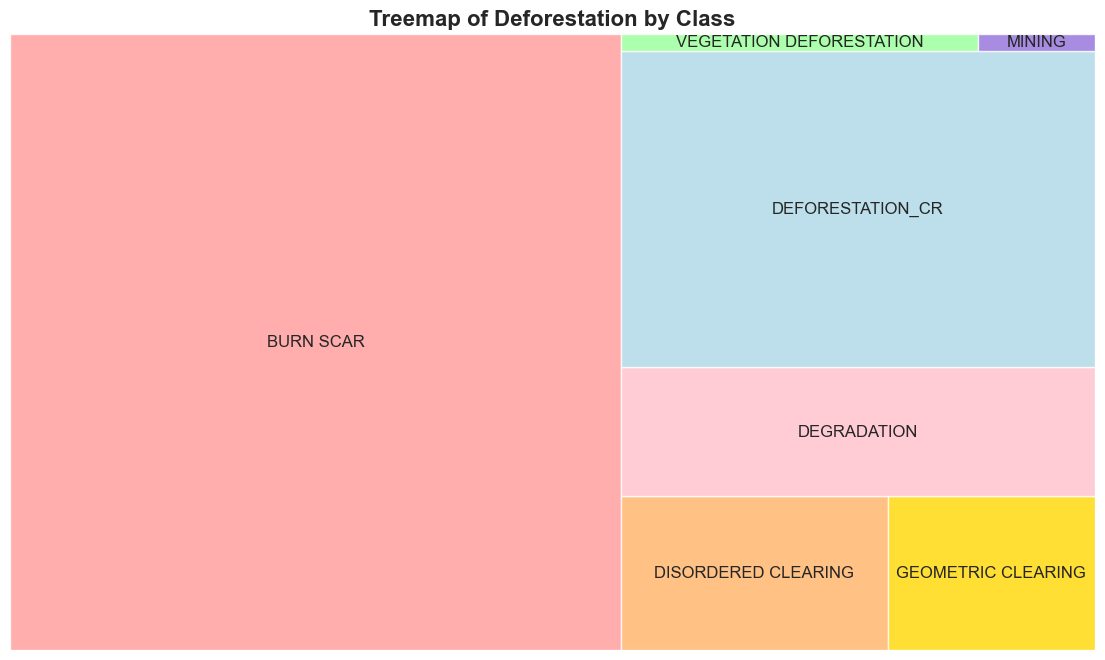

In [ ]:
import matplotlib.pyplot as plt
import squarify

# Custom Color Palette Function with a more diverse color scheme
def palette_gen(n_colors):
    """
    Generates a more diverse color palette to ensure high contrast between colors.

    Parameters:
        n_colors (int): Number of colors to return from the predefined palette.

    Returns:
        list: A list of hex color codes from the predefined palette.
    """
    # Updated diverse color palette
    base_palette = [
        '#FF9999',  # light pink
        '#FFB266',  # light orange
        '#FFD700',  # gold
        '#FFC0CB',  # pink
        '#ADD8E6',  # light blue
        '#98FF98',  # mint green
        '#9370DB',  # medium purple
        '#20B2AA',  # light sea green
        '#FFA07A'   # light salmon
    ]
    
    # Repeat the palette or slice to fit n_colors
    if n_colors <= len(base_palette):
        return base_palette[:n_colors]
    else:
        # Extend the palette if n_colors is greater than the length of base_palette
        return (base_palette * (n_colors // len(base_palette) + 1))[:n_colors]

def deter_graph12():
    """
    Creates a treemap visualization of deforestation by class with English labels.

    Returns:
        fig, ax: Matplotlib figure and axis objects for further processing or saving.
    """
    # Group by CLASSNAME and sum up the AREAMUNKM values
    df_treemap = df_deter.groupby('CLASSNAME')['AREAMUNKM'].sum().reset_index()

    # Define the translation dictionary
    translation_dict = {
        'CICATRIZ_DE_QUEIMADA': 'BURN SCAR',
        'DESMATAMENTO_CR': 'DEFORESTATION_CR',
        'DEGRADACAO': 'DEGRADATION',
        'DESMATAMENTO_VEG': 'VEGETATION DEFORESTATION',
        'MINERACAO': 'MINING',
        'CS_DESORDENADO': 'DISORDERED CLEARING',
        'CS_GEOMETRICO': 'GEOMETRIC CLEARING'
    }

    # Apply the translation to the CLASSNAME column
    df_treemap['CLASSNAME_EN'] = df_treemap['CLASSNAME'].map(translation_dict)

    # Generate the color palette with the correct number of colors
    colors = palette_gen(n_colors=len(df_treemap))

    # Plot the treemap with English labels and custom color palette
    fig, ax = plt.subplots(figsize=(14, 8))
    squarify.plot(
        sizes=df_treemap['AREAMUNKM'], 
        label=df_treemap['CLASSNAME_EN'], 
        color=colors,
        alpha=0.8, 
        ax=ax
    )
    ax.set_title("Treemap of Deforestation by Class", fontsize=16, fontweight='bold')
    ax.axis('off')

    # Display the plot and return fig, ax for save_graph
    plt.show()
    return fig, ax

# Example usage with save_graph
save_graph("treemap", deter_graph12)
